In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
# import leafmap.leafmap as leafmap
import leafmap.foliumap as leafmap
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from typing import List, Tuple
from scipy.ndimage import zoom
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import cv2
import skfmm

In [2]:
# Caminhos
raster_path = '../LiDAR_produtos/2017/BHM-2017-50cm.tiff'   # raster

# Carregar feições
gdf = gpd.read_file('data/SIRGAS_GPKG_favela.gpkg')
gdf.geometry = gdf.buffer(0)

In [3]:
# Selecionar a feição (exemplo: primeira)
favela_geom = gdf.loc[gdf.fv_nome == 'São Remo', :].geometry.values.tolist()

favelas_test = [
    "Heliópolis",
    "Cocaia I",
    "Paraisópolis",
    "Futuro Melhor",
    "São Remo"
]

In [4]:
# Selecionando gdf com a coluna 'fv_nome'
favelas_filtradas = gdf[gdf['fv_nome'].isin(favelas_test)]

In [5]:
favelas_filtradas.dissolve(by='fv_nome').reset_index()

,fv_nome,geometry,fv_data,fv_nom_sec,fv_tp_prop,fv_domicil
0,Cocaia I,"POLYGON ((329257.063 7372067.335, 329264.199 7...",2016-04-20,-,1,618
1,Futuro Melhor,"POLYGON ((329713.897 7405216.47, 329710.844 74...",2016-04-12,Peri Alto,1,1500
2,Heliópolis,"MULTIPOLYGON (((337198.456 7388304.423, 337197...",2016-04-04,-,1,15843
3,Paraisópolis,"POLYGON ((323327.527 7386833.606, 323328.54 73...",2016-04-18,-,1,17159
4,São Remo,"POLYGON ((322040.878 7393008.182, 321974.935 7...",2017-08-03,-,1,2000


In [6]:
# Abrir raster e recortar pela feição
with rasterio.open(raster_path) as src:
    print("Raster CRS:", src.crs)
    print("Bounds do raster:", src.bounds)
    print("Bounds da favela 0:", gdf.loc[gdf.fv_nome == 'São Remo', :].geometry.bounds)
    out_image, out_transform = mask(src, favela_geom, crop=True)
    out_data = out_image[0]

    # Filtrar valores válidos
    valid_data = out_data[out_data != src.nodata]

# Ordenar os valores
sorted_data = np.sort(valid_data)

Raster CRS: EPSG:31983
Bounds do raster: BoundingBox(left=313179.5, bottom=7343480.5, right=360683.0, top=7416432.5)
Bounds da favela 0:               minx          miny           maxx          maxy
668  321740.305639  7.392975e+06  322166.723848  7.393369e+06


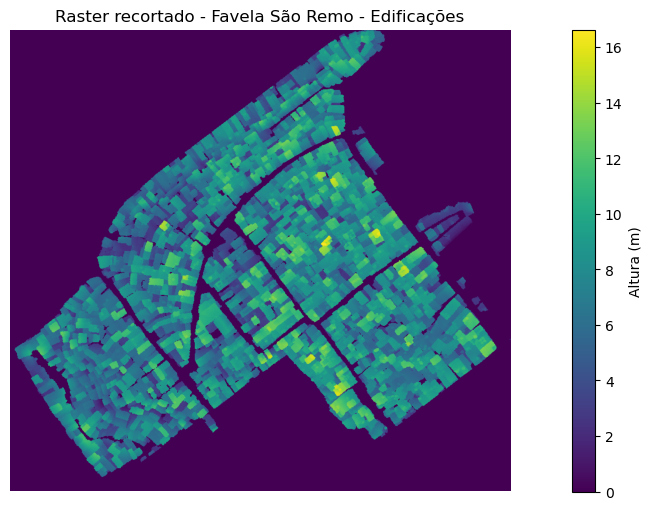

In [7]:
# Plot simples com colormap
plt.figure(figsize=(16, 6))
plt.imshow(out_data, cmap='viridis')
plt.colorbar(label="Altura (m)")
plt.title("Raster recortado - Favela São Remo - Edificações")
plt.axis('off')
plt.show()

In [8]:
out_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(789, 854), dtype=float32)

In [9]:
mask_favela = geometry_mask(
    geometries=favela_geom,
    transform=out_transform,
    invert=True,  # True = interior da geometria será False (mapeado)
    out_shape=out_data.shape
)

In [40]:
np.unique(mask_favela, return_counts=True)

(array([False,  True]), array([343271, 330535]))

In [10]:
# Binarização: cheios = 1, vazios = 0
vazios = np.where(((out_data == 0.) & (mask_favela)), 1., 0.)

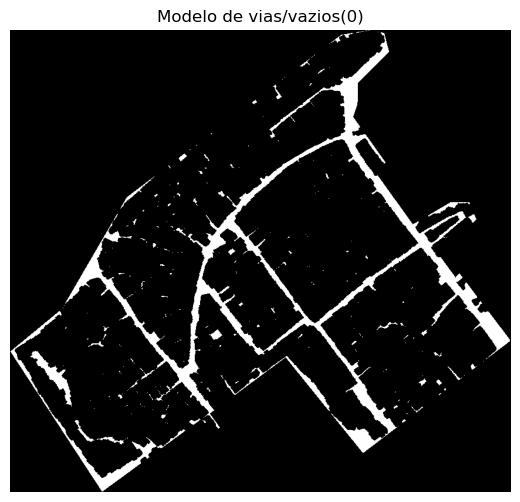

In [11]:
plt.figure(figsize=(8, 6))
plt.imshow(vazios, cmap='gray')
plt.title("Modelo de vias/vazios(0)")
plt.axis('off')
plt.show()

In [12]:
tamanho_pixel_base = 0.5  # metros, por exemplo
niveis = 10

tamanhos_por_nivel = [tamanho_pixel_base * (2 ** n) for n in range(niveis)]
print(tamanhos_por_nivel)

[0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0]


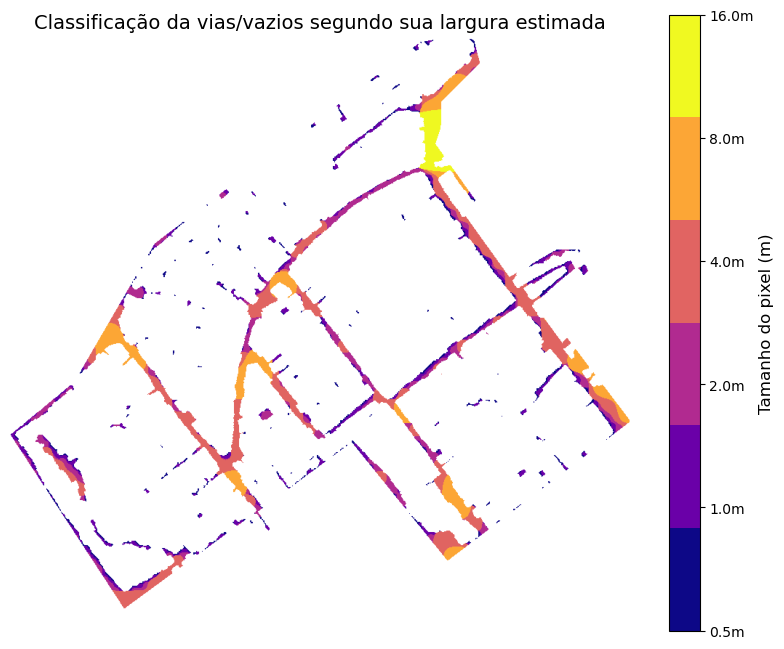

In [13]:
# --- Função para gerar a pirâmide com convolução ---
def gerar_piramide_convolucional_maioria(base_array: np.ndarray, pixel_size_base: float, niveis: int = 6):
    piramide = [base_array.copy()]
    resolucoes = [pixel_size_base]
    atual = base_array.copy()

    for _ in range(1, niveis):
        kernel = np.ones((3, 3), dtype=int)
        conv = convolve(atual, kernel, mode='constant', cval=0)
        maioria = (conv >= 5).astype(np.uint8)

        h, w = maioria.shape
        h_crop = h - (h % 2)
        w_crop = w - (w % 2)
        reduzido = maioria[:h_crop, :w_crop].reshape(h_crop // 2, 2, w_crop // 2, 2).mean(axis=(1, 3)) >= 0.5
        reduzido = reduzido.astype(np.uint8)

        piramide.append(reduzido)
        resolucoes.append(resolucoes[-1] * 2)
        atual = reduzido

    return piramide, resolucoes

# --- Propagação completa incluindo nível 0 ---
def propagar_para_base_convolucional(vazios: np.ndarray, piramide: List[np.ndarray]) -> np.ndarray:
    base_shape = vazios.shape
    resultado = np.zeros(base_shape, dtype=np.uint8)

    for nivel in reversed(range(len(piramide))):  # agora inclui o nível 0
        reduzido = piramide[nivel]
        escala_y = base_shape[0] / reduzido.shape[0]
        escala_x = base_shape[1] / reduzido.shape[1]

        upscaled = zoom(reduzido, (escala_y, escala_x), order=2)

        upscaled_corrigido = np.zeros(base_shape, dtype=np.uint8)
        h, w = upscaled.shape
        upscaled_corrigido[:h, :w] = upscaled[:base_shape[0], :base_shape[1]]

        mask = (resultado == 0) & (upscaled_corrigido == 1) & (vazios == 1)
        resultado[mask] = nivel

    return resultado

# === EXEMPLO DE USO ===

# Suponha que você tenha a matriz `vazios` e o tamanho do pixel base
# pixel_size_base = 0.5
# vazios = np.random.choice([0, 1], size=(150, 150), p=[0.7, 0.3])

n_niveis = 10
piramide, resolucoes = gerar_piramide_convolucional_maioria(vazios, pixel_size_base=0.5, niveis=n_niveis)
resultado_final = propagar_para_base_convolucional(vazios, piramide)

# --- Máscara para ocultar os pixels de nível 0 ---
dados_mascarados = np.ma.masked_where(resultado_final == 0, resultado_final)

# --- Colormap ---
n_niveis = resultado_final.max()  # considera até o maior nível atribuído
cmap = cm.get_cmap('plasma', n_niveis)
cmap.set_bad(color='white')  # nível 0 oculto em branco

# --- Plotagem ---
plt.figure(figsize=(10, 8))
im = plt.imshow(dados_mascarados, cmap=cmap)

# --- Ajustar os ticks para os níveis presentes (1 até n_niveis) ---
ticks = list(range(1, n_niveis + 1))
labels = [f"{resolucoes[i - 1]:.1f}m" for i in ticks]  # i-1 porque resolucoes[0] = nível 1

# --- Colorbar com rótulos corretos ---
cbar = plt.colorbar(im, ticks=ticks)
cbar.set_label("Tamanho do pixel (m)", fontsize=12)
cbar.set_ticklabels(labels)

plt.title("Classificação da vias/vazios segundo sua largura estimada", fontsize=14)
plt.axis('off')
plt.show()

In [16]:
# # --- Parâmetros ---
# pixel_size_base = 0.5
# n_niveis = 8  # número de níveis desejados
# vazios_iter = vazios.copy()
# resultado = np.zeros_like(vazios, dtype=np.uint8)
# resolucoes = [pixel_size_base * (2 ** i) for i in range(n_niveis-1)]
# print(resolucoes)

# for nivel in range(1, n_niveis):
#     # tamanho_janela = 2 ** nivel + 1
#     tamanho_janela = 3
#     # print(tamanho_janela)
#     kernel = np.ones((tamanho_janela, tamanho_janela), dtype=int)
#     conv = convolve(vazios_iter, kernel, mode='constant', cval=0)

#     if np.any(vazios_iter):
#         # Upscale para manter o shape original do raster base
#         vazios_iter_full = np.zeros_like(vazios)
#         fator_y = vazios.shape[0] // vazios_iter.shape[0]
#         fator_x = vazios.shape[1] // vazios_iter.shape[1]
#         vazios_iter = np.kron(vazios_iter, np.ones((fator_y, fator_x), dtype=np.uint8))
#         vazios_iter = vazios_iter[:vazios.shape[0], :vazios.shape[1]]  # recorte final
#         conv = np.kron(conv, np.ones((fator_y, fator_x), dtype=np.uint8))
#         conv = conv[:vazios.shape[0], :vazios.shape[1]]  # recorte final

#     limite = kernel.sum() // 2  # até metade dos vizinhos
#     isolados = (vazios_iter == 1) & (conv <= limite)
#     # if nivel == 2:
#     #     break
#     # Corrigir shape do isolados para bater com resultado
#     if isolados.shape != resultado.shape:
#         h, w = isolados.shape
#         isolados_corrigido = np.zeros_like(resultado, dtype=bool)
#         isolados_corrigido[:h, :w] = isolados
#         isolados_resultado = isolados_corrigido

#     resultado[isolados_resultado] = nivel + 1  # marca com valor do nível

#     # Corrigir shape do isolados para bater com resultado
#     if isolados.shape != vazios_iter.shape:
#         h, w = isolados.shape
#         isolados_corrigido = np.zeros_like(vazios_iter, dtype=bool)
#         isolados_corrigido[:h, :w] = isolados
#         isolados_vazio = isolados_corrigido

#     vazios_iter[isolados] = 0  # remove esses pixels para próximas iterações

#     # --- Downsampling com agregação por média ---
#     h, w = vazios_iter.shape
#     fator = nivel * 2
#     h_crop = h - (h % fator)
#     w_crop = w - (w % fator)
#     bloco = vazios_iter[:h_crop, :w_crop].reshape(h_crop // fator, fator, w_crop // fator, fator)
#     media = bloco.mean(axis=(1, 3))
#     vazios_iter = (media > 0.5).astype(np.uint8)

# # --- Visualização ---
# mascara = resultado == 0
# dados_mascarados = np.ma.masked_where(mascara, resultado)

# cmap = cm.get_cmap('plasma', n_niveis)
# cmap.set_bad(color='white')

# plt.figure(figsize=(10, 8))
# im = plt.imshow(dados_mascarados, cmap=cmap)

# nivel_max = resultado.max()
# ticks = list(range(1, nivel_max + 1))
# labels = [f"{resolucoes[i-1]:.1f}m" for i in ticks]

# cbar = plt.colorbar(im, ticks=ticks)
# cbar.set_ticklabels(labels)
# cbar.set_label("Tamanho do pixel (m)", fontsize=12)

# plt.title("Classificação hierárquica por isolamento (sem zoom)", fontsize=14)
# plt.axis('off')
# plt.show()


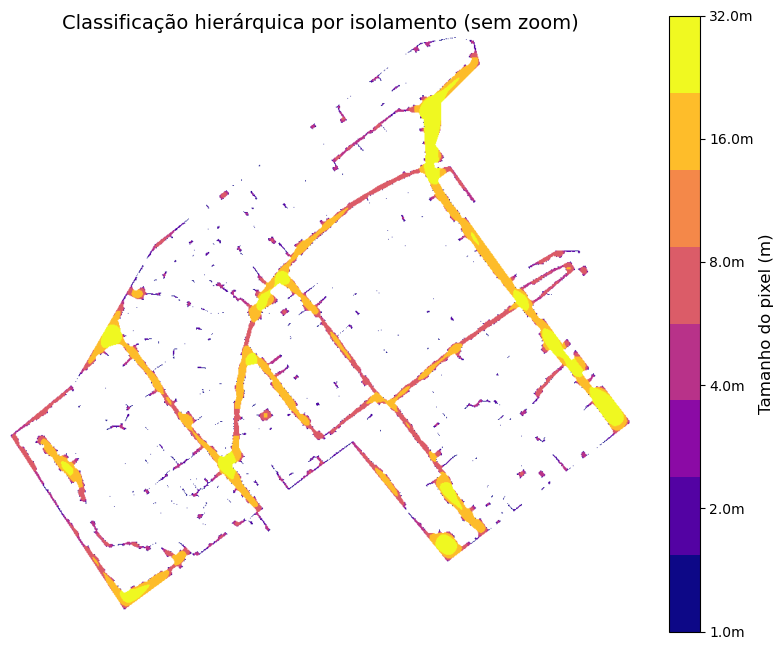

In [ ]:
# --- Parâmetros ---
pixel_size_base = 0.5
n_niveis = 8  # número de níveis desejados
vazios_iter = vazios.copy()
resultado = np.zeros_like(vazios, dtype=np.uint8)
resolucoes = [pixel_size_base * (2 ** i) for i in range(n_niveis)]

# --- Processamento hierárquico com janelas crescentes ---
for nivel in range(1, n_niveis + 1):
    tamanho_janela = 2 ** nivel + 1
    # print(tamanho_janela)
    kernel = np.ones((tamanho_janela, tamanho_janela), dtype=int)
    conv = convolve(vazios_iter, kernel, mode='constant', cval=0)
    limite = kernel.sum() // 2  # até metade dos vizinhos

    isolados = (vazios_iter == 1) & (conv <= limite)

    resultado[isolados] = nivel + 1  # marca com valor do nível
    vazios_iter[isolados] = 0  # remove esses pixels para próximas iterações

# --- Visualização ---
mascara = resultado == 0
dados_mascarados = np.ma.masked_where(mascara, resultado)

cmap = cm.get_cmap('plasma', n_niveis)
cmap.set_bad(color='white')

plt.figure(figsize=(10, 8))
im = plt.imshow(dados_mascarados, cmap=cmap)

ticks = list(range(1, n_niveis + 1))
labels = [f"{resolucoes[i-1]:.1f}m" for i in ticks]

cbar = plt.colorbar(im, ticks=ticks)
cbar.set_ticklabels(labels)
cbar.set_label("Tamanho do pixel (m)", fontsize=12)

plt.title("Classificação hierárquica por isolamento (sem zoom)", fontsize=14)
plt.axis('off')
plt.show()

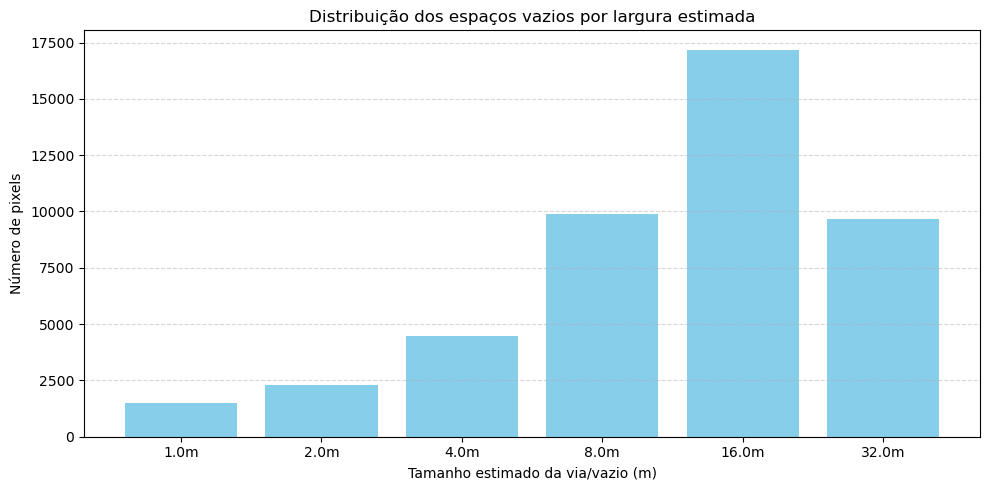

In [ ]:
# --- Histograma dos níveis atribuídos (ignorando 0) ---
valores, contagens = np.unique(resultado, return_counts=True)
valores = valores[valores > 0]
contagens = contagens[1:]  # Ignora o nível 0 (não classificados)

# Rótulos baseados na resolução
labels = [f"{resolucoes[nivel-1]:.1f}m" for nivel in valores]

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.bar(labels, contagens, color='skyblue')
plt.xlabel("Tamanho estimado da via/vazio (m)")
plt.ylabel("Número de pixels")
plt.title("Distribuição dos espaços vazios por largura estimada")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

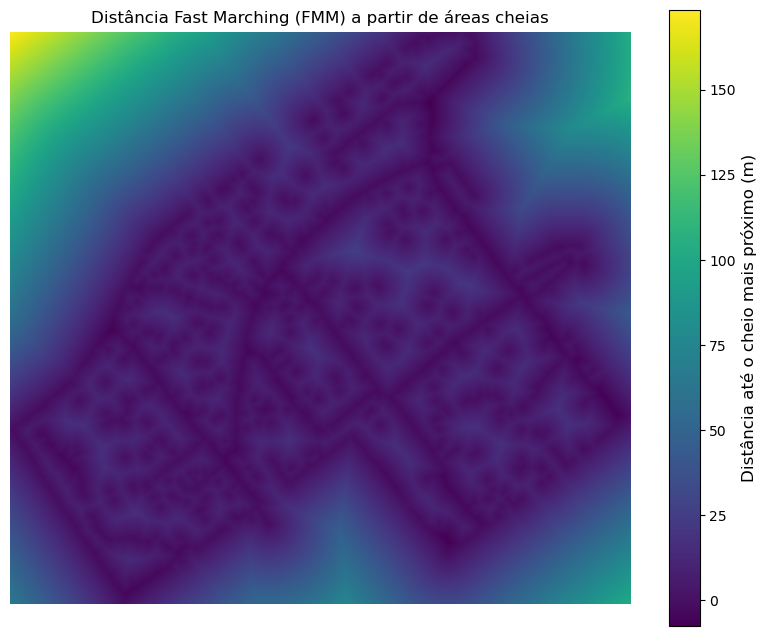

In [19]:
# --- Parâmetros do raster ---
pixel_size_base = 0.5  # tamanho de pixel em metros (ajuste se necessário)

# --- Raster binário de entrada ---
# Supondo que você já tenha a variável `vazios` definida
# 0 = cheio (obstáculo), 1 = vazio (passável)

# --- Construir phi: -1 nos cheios, +1 nos vazios ---
phi = np.where(vazios == 1, -1.0, 1.0)

# --- Aplicar Fast Marching Method ---
distance = skfmm.distance(phi, dx=pixel_size_base)

# --- Visualização ---
plt.figure(figsize=(10, 8))
masked_dist = np.ma.masked_where(np.isnan(distance), distance)
im = plt.imshow(masked_dist, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('Distância até o cheio mais próximo (m)', fontsize=12)
plt.title('Distância Fast Marching (FMM) a partir de áreas cheias')
plt.axis('off')
plt.show()


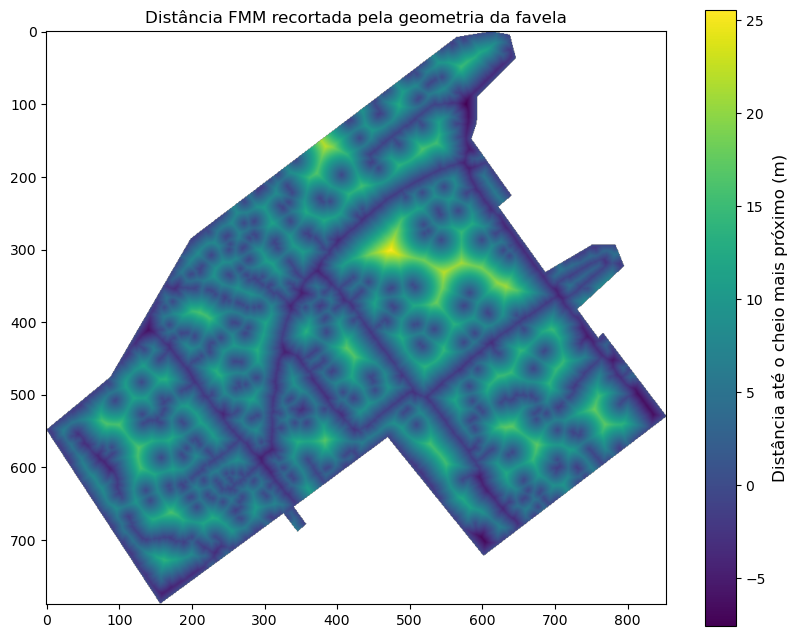

In [44]:
# --- Parâmetros do raster ---
pixel_size_base = 0.5  # tamanho de pixel em metros (ajuste se necessário)

# --- Raster binário de entrada ---
# Supondo que você já tenha a variável `vazios` definida
# 0 = cheio (obstáculo), 1 = vazio (passável)

# --- Construir phi: -1 nos cheios, +1 nos vazios ---
phi = np.where(vazios == 1, -1.0, 1.0)

# --- Aplicar Fast Marching Method ---
distance = skfmm.distance(phi, dx=pixel_size_base)

# Máscara invertida: queremos ocultar onde NÃO está na favela
dist_masked = np.ma.masked_where(~mask_favela, distance)

# Plotagem
plt.figure(figsize=(10, 8))
im = plt.imshow(dist_masked, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('Distância até o cheio mais próximo (m)', fontsize=12)
plt.title("Distância FMM recortada pela geometria da favela")
plt.axis('on')
plt.show()




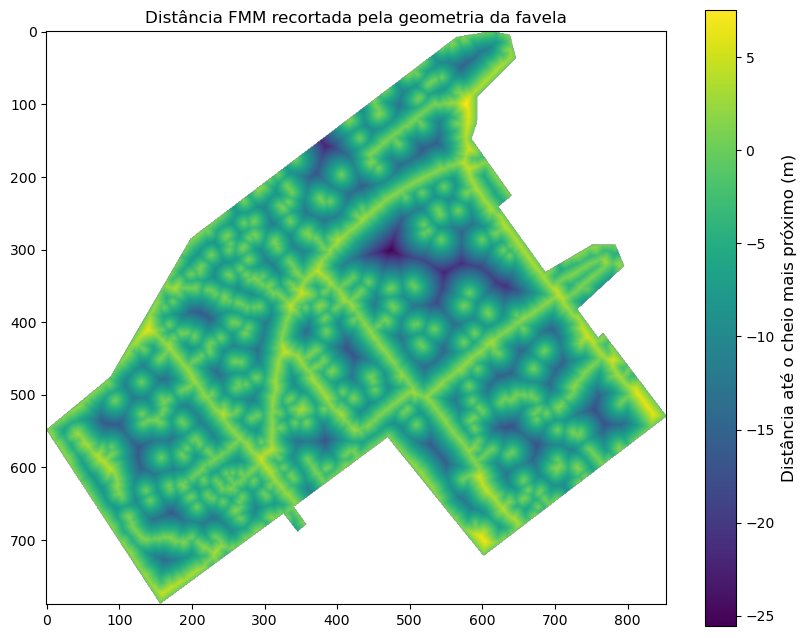

In [45]:
# --- Parâmetros do raster ---
pixel_size_base = 0.5  # tamanho de pixel em metros (ajuste se necessário)

# --- Raster binário de entrada ---
# Supondo que você já tenha a variável `vazios` definida
# 0 = cheio (obstáculo), 1 = vazio (passável)

# --- Construir phi: -1 nos cheios, +1 nos vazios ---
phi = np.where(vazios == 0, -1.0, 1.0)

# --- Aplicar Fast Marching Method ---
distance = skfmm.distance(phi, dx=pixel_size_base)

# Máscara invertida: queremos ocultar onde NÃO está na favela
dist_masked = np.ma.masked_where(~mask_favela, distance)

# Plotagem
plt.figure(figsize=(10, 8))
im = plt.imshow(dist_masked, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('Distância até o cheio mais próximo (m)', fontsize=12)
plt.title("Distância FMM recortada pela geometria da favela")
plt.axis('on')
plt.show()

In [50]:
vazios.shape

(789, 854)

In [ ]:
def agrupar_sequencias_1s(m):
    """Retorna uma matriz com grupos de 1 substituídos pelo tamanho da sequência."""
    output = np.zeros_like(m)
    for i, linha in enumerate(m):
        dif = np.diff(np.concatenate(([0], linha, [0])))
        inicios = np.where(dif == 1)[0]
        fins    = np.where(dif == -1)[0]
        for start, end in zip(inicios, fins):
            comprimento = end - start
            output[i, start:end] = comprimento
    return output

# Aplicar por linha (direto) e por coluna (transposta)
saida_linhas = agrupar_sequencias_1s(vazios)
saida_colunas = agrupar_sequencias_1s(vazios.T).T  # Transpõe, processa por linha, volta

# Combinar heurísticas (ex: soma, média, mínimo...)
heuristica_combinada = np.minimum(saida_linhas, saida_colunas)


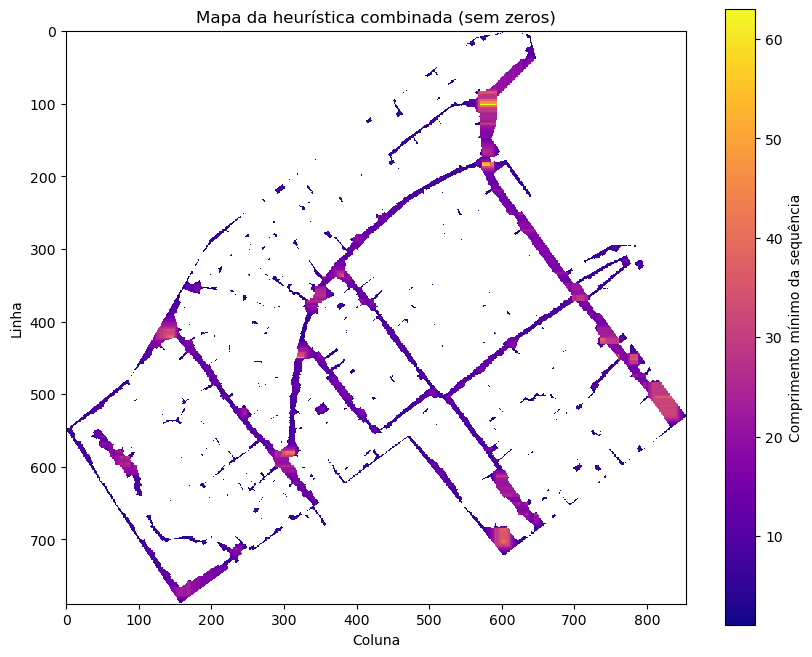

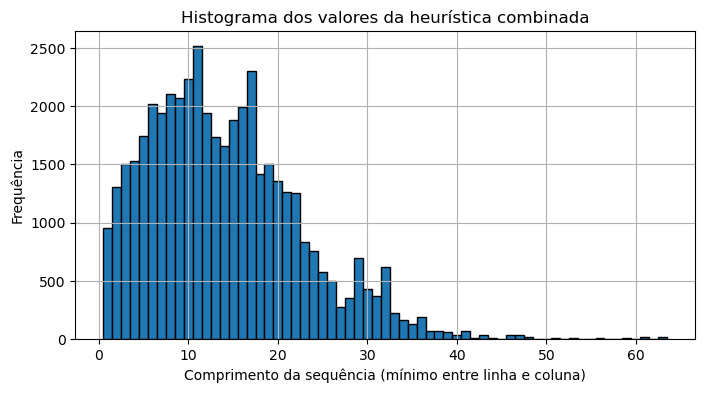

In [59]:
# === PLOT DO MAPA (OCULTANDO ZEROS) ===
mascara = heuristica_combinada.astype(float)
mascara[mascara == 0] = np.nan  # Oculta zeros

plt.figure(figsize=(10, 8))
plt.imshow(mascara, cmap='plasma', interpolation='nearest')
plt.colorbar(label='Comprimento mínimo da sequência')
plt.title('Mapa da heurística combinada (sem zeros)')
plt.xlabel('Coluna')
plt.ylabel('Linha')
plt.show()

# === PLOT DO HISTOGRAMA ===
valores = heuristica_combinada[heuristica_combinada > 0]
plt.figure(figsize=(8, 4))
plt.hist(valores, bins=np.arange(1, valores.max() + 2) - 0.5, edgecolor='black')
plt.title('Histograma dos valores da heurística combinada')
plt.xlabel('Comprimento da sequência (mínimo entre linha e coluna)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

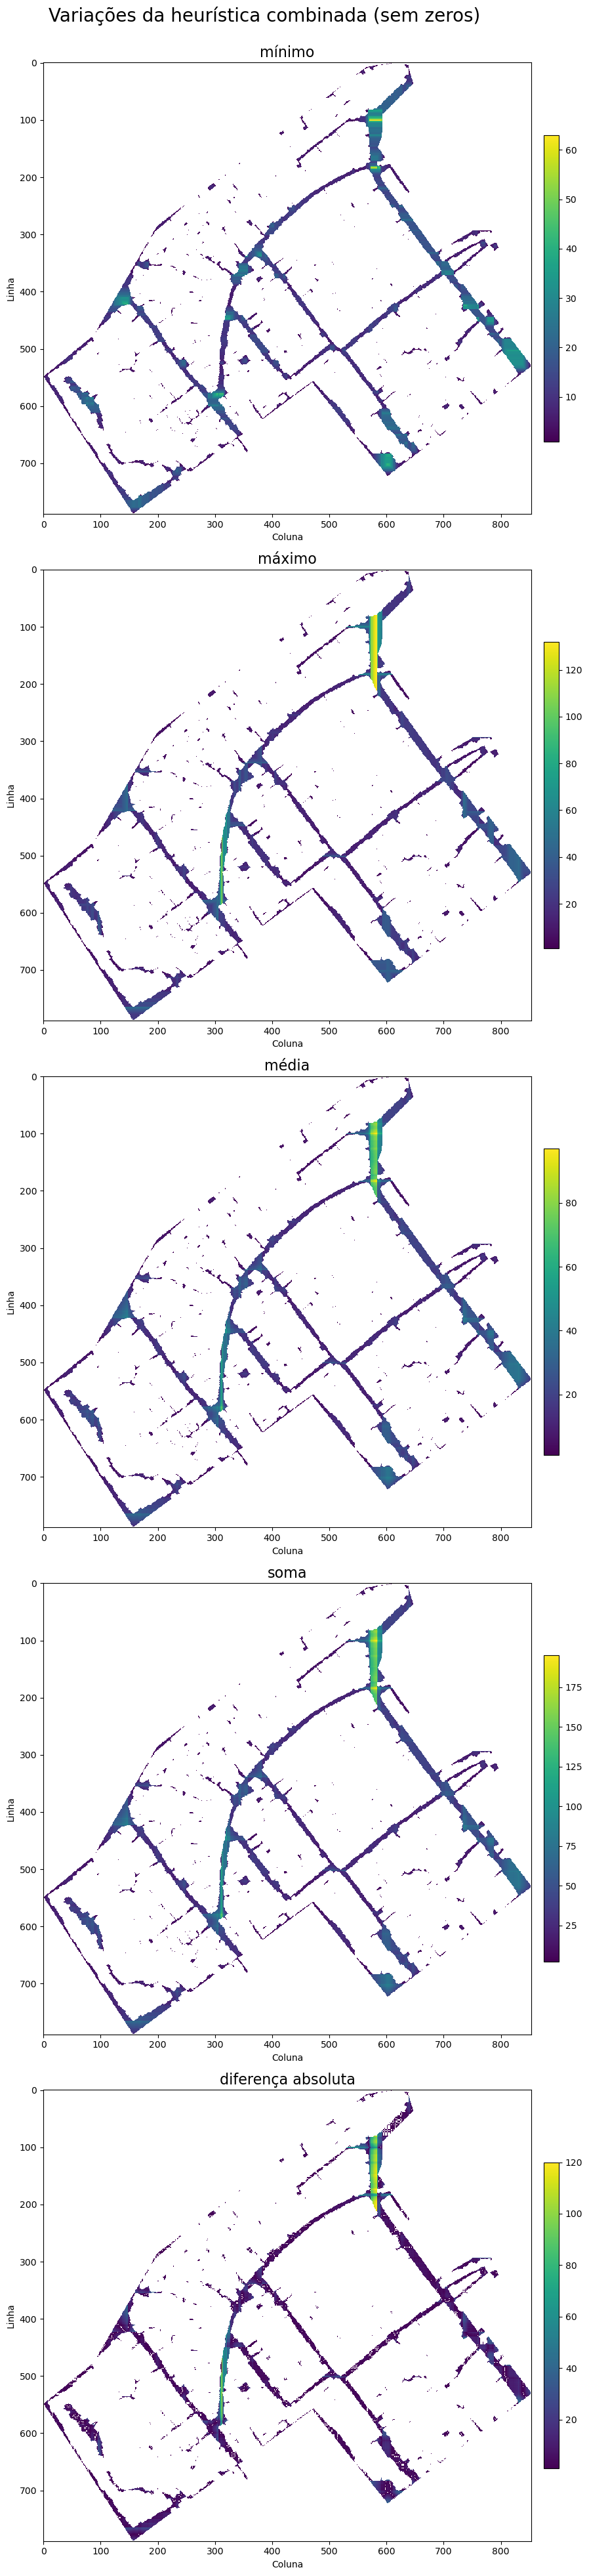

In [64]:
# === COMBINAÇÕES DE HEURÍSTICAS ===
combinacoes = {
    'mínimo': np.minimum(saida_linhas, saida_colunas),
    'máximo': np.maximum(saida_linhas, saida_colunas),
    'média': ((saida_linhas + saida_colunas) / 2).astype(int),
    'soma': saida_linhas + saida_colunas,
    'diferença absoluta': np.abs(saida_linhas - saida_colunas)
}

# === PLOTAGEM EM LINHAS (UM MAPA POR LINHA) ===
num_mapas = len(combinacoes)
fig, axs = plt.subplots(num_mapas, 1, figsize=(10, 8 * num_mapas))

# Garante que axs seja iterável mesmo com 1 único gráfico
if num_mapas == 1:
    axs = [axs]

for ax, (titulo, matriz) in zip(axs, combinacoes.items()):
    # Aplicar máscara para esconder os valores 0
    mascara = matriz.astype(float)
    mascara[mascara == 0] = np.nan

    # Plotar
    im = ax.imshow(mascara, cmap='viridis', interpolation='nearest')
    ax.set_title(titulo, fontsize=16)
    ax.set_xlabel("Coluna")
    ax.set_ylabel("Linha")
    fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02)

plt.suptitle('Variações da heurística combinada (sem zeros)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

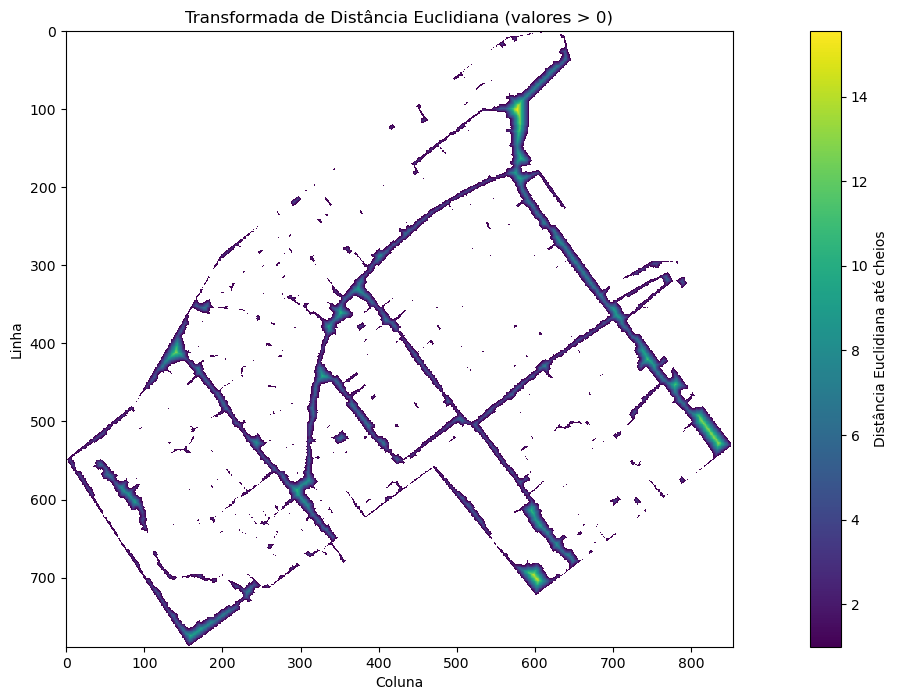

In [74]:
from scipy.ndimage import distance_transform_edt

# === CALCULAR A DISTÂNCIA EUCLIDIANA PARA PIXELS CHEIOS ===
# Inverter: queremos a distância dos vazios (0s) até os cheios (1s)
inverso = vazios == 1

# Calcula a distância Euclidiana
distancia = distance_transform_edt(inverso)

# === MASCARAR OS PIXELS ONDE A DISTÂNCIA É ZERO (ou seja, cheios) ===
distancia_filtrada = distancia.astype(float)
distancia_filtrada[distancia_filtrada == 0] = np.nan  # Oculta os cheios

# === PLOTAGEM ===
plt.figure(figsize=(20, 8))
plt.imshow(distancia_filtrada, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Distância Euclidiana até cheios")
plt.title("Transformada de Distância Euclidiana (valores > 0)")
plt.xlabel("Coluna")
plt.ylabel("Linha")
plt.show()